In [ ]:
!pip install scikit-ntk

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import re
from sklearn.manifold import TSNE
import csv
from collections import Counter, defaultdict
import math
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import xgboost as xgb
import gensim
import gensim.downloader
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from skntk import NeuralTangentKernel as NTK
import ast



In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/preprocessed_data.csv")

Word Emdeddings


In [ ]:


def tokens(column, n):
    tokens = []
    column_name = f'{n}-gram'
    df = pd.DataFrame({column_name: [None] * len(column)})
    for idx, line in enumerate(column):
        if isinstance(line, str):
            words = line.strip().split()
            words = [''] * (n - 1) + words + [''] * (n - 1)
            df.at[idx, column_name] = words
            for i in range(len(words) - n + 1):
                tokens.append(tuple(words[i:i + n]))

    return tokens, df

def probability(tokens, unique_tokens):
    token_counts = defaultdict(int)
    prefix_counts = defaultdict(int)

    for token in tokens:
        token_counts[token] += 1
        prefix_counts[token[:-1]] += 1

    probabilities = {}
    for unique_token in unique_tokens:
        count_a = token_counts[unique_token]
        count_b = prefix_counts[unique_token[:-1]]
        probabilities[unique_token] = count_a / count_b if count_b > 0 else 0

    return probabilities

data = df  # Use your actual DataFrame here
n = 4
input_column = data['preprocessed_joke']

# Generate n-grams and DataFrame with n-grams
grams, gram_data = tokens(input_column, n)
unique_grams = set(grams)

gram_data.to_csv("4gram-words.csv", index=False)

# Calculate probabilities of n-grams
ngram_probabilities = probability(grams, unique_grams)

# Save n-gram probabilities to CSV without sorting
with open('4gram_prob.csv', 'w', newline='', encoding='utf-8') as csvfile:
    fieldnames = ['Ngram', 'Probability']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()
    for token, prob in ngram_probabilities.items():
        writer.writerow({'Ngram': ' '.join(token), 'Probability': prob})



In [ ]:
import pandas as pd
import ast

def probability_token(gram_data, output_dict):
    processed_data = []
    for tokens_list in gram_data['tokens']:
        subsets_of_three = []
        for i in range(len(tokens_list) - 3):
            subset = " ".join(str(token) for token in tokens_list[i:i+4])  # Ensure all tokens are strings
            subsets_of_three.append(subset)

        del subsets_of_three[-3:]
        for i, subset in enumerate(subsets_of_three):
            if subset in output_dict:
                probability = output_dict[subset]
                subsets_of_three[i] = probability
        processed_data.append(subsets_of_three)
    return processed_data

# Read gram data
gram_data = pd.read_csv('/content/4gram-words.csv')
# Convert string representation of list to actual list
# Handle missing or malformed data
gram_data['4-gram'] = gram_data['4-gram'].fillna('[]')
gram_data['tokens'] = gram_data['4-gram'].apply(lambda x: ast.literal_eval(x))

# Read output data
output_dict = {}
with open('/content/4gram_prob.csv', 'r', encoding='utf-8') as f:
    lines = f.readlines()
    lines.pop(0)
    for line in lines:
        phrase, probability = line.split(",")
        output_dict[phrase] = float(probability)

# Process data
probability_values = probability_token(gram_data, output_dict)

# Create a new DataFrame
new_df = pd.DataFrame({'4-gram': gram_data['4-gram'], '4-gram Probability values': probability_values})

# Print the new DataFrame
new_df.to_csv("4-gram_probs.csv", index=False)

In [74]:
import pandas as pd
import ast

# Read input data
gram_data = pd.read_csv('/content/4-gram_probs.csv')

# Convert string representation of list to actual list, handling NaN values
gram_data['tokens'] = gram_data['4-gram Probability values'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else [])

# Find the maximum length of the TF-IDF vectors
max_length = max(gram_data['4-gram Probability values'].apply(len))

# Append zeros to the lists to match the maximum length
gram_data['tokens'] = gram_data['tokens'].apply(lambda x: x + [0] * (max_length - len(x)))


# Save the modified DataFrame to a new CSV file
gram_data.to_csv('padded_4gram.csv', index=False)

# Example of accessing the modified DataFrame
print(gram_data.head())


                                              4-gram  \
0  ['', '', '', 'fan', 'music', 'group', 'lead', ...   
1  ['', '', '', 'optimist', 'say', 'cup', 'half',...   
2  ['', '', '', 'guy', 'broken', 'neck', 'stole',...   
3  ['', '', '', 'jumper', 'cable', 'walk', 'bar',...   
4  ['', '', '', 'melted', 'ice', 'cube', 'staring...   

                           4-gram Probability values  \
0  [0.00018299935950224174, 0.25, 1.0, 1.0, 1.0, ...   
1  [0.00018299935950224174, 0.5, 0.5, 1.0, 0.5, 0...   
2  [0.006404977582578461, 0.007142857142857143, 1...   
3  [0.0001372495196266813, 1.0, 1.0, 0.5, 0.5, 0....   
4  [4.5749839875560434e-05, 1.0, 1.0, 1.0, 1.0, 1...   

                                              tokens  
0  [0.00018299935950224174, 0.25, 1.0, 1.0, 1.0, ...  
1  [0.00018299935950224174, 0.5, 0.5, 1.0, 0.5, 0...  
2  [0.006404977582578461, 0.007142857142857143, 1...  
3  [0.0001372495196266813, 1.0, 1.0, 0.5, 0.5, 0....  
4  [4.5749839875560434e-05, 1.0, 1.0, 1.0, 1.0, 1..

In [76]:
import pandas as pd
import ast
from sklearn.decomposition import TruncatedSVD

# Read input data
gram_data = pd.read_csv('/content/modified_english_with_4gram.csv')

# Convert string representation of list to actual list, handling NaN values
gram_data['tokens'] = gram_data['tokens'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else [])

# Convert the 'tokens' column to a list of lists
token_matrix = gram_data['tokens'].tolist()

# Apply SVD to reduce the dimensionality
n_components = 100  # Choose the number of dimensions you want to reduce to
svd = TruncatedSVD(n_components=n_components, random_state=42)
reduced_matrix = svd.fit_transform(token_matrix)

# Add the reduced vectors back to the DataFrame
for i in range(n_components):
    gram_data[f'svd_component_{i+1}'] = reduced_matrix[:, i]

# Drop the original 'tokens' column
gram_data.drop(columns=['tokens'], inplace=True)

# Save the modified DataFrame to a new CSV file
gram_data.to_csv('reduced_4gram.csv', index=False)

# Example of accessing the modified DataFrame
print(gram_data.head())


<ipython-input-76-08b0f6697b07>:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  gram_data[f'svd_component_{i+1}'] = reduced_matrix[:, i]
<ipython-input-76-08b0f6697b07>:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  gram_data[f'svd_component_{i+1}'] = reduced_matrix[:, i]


                                              4-gram  \
0  ['', '', '', 'fan', 'music', 'group', 'lead', ...   
1  ['', '', '', 'optimist', 'say', 'cup', 'half',...   
2  ['', '', '', 'guy', 'broken', 'neck', 'stole',...   
3  ['', '', '', 'jumper', 'cable', 'walk', 'bar',...   
4  ['', '', '', 'melted', 'ice', 'cube', 'staring...   

                           4-gram Probability values  svd_component_1  \
0  [0.00018299935950224174, 0.25, 1.0, 1.0, 1.0, ...         0.473905   
1  [0.00018299935950224174, 0.5, 0.5, 1.0, 0.5, 0...         0.496396   
2  [0.006404977582578461, 0.007142857142857143, 1...         0.351418   
3  [0.0001372495196266813, 1.0, 1.0, 0.5, 0.5, 0....         0.377824   
4  [4.5749839875560434e-05, 1.0, 1.0, 1.0, 1.0, 1...         0.489362   

   svd_component_2  svd_component_3  svd_component_4  svd_component_5  \
0        -0.626649         2.127167        -0.883266         1.015153   
1        -0.610886         1.812815        -0.597761         0.384909   
2    

In [77]:
# Assuming your dataset also contains labels in 'label' column
labels = data['joke_type']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(reduced_matrix, labels, test_size=0.2, random_state=42)


tsne

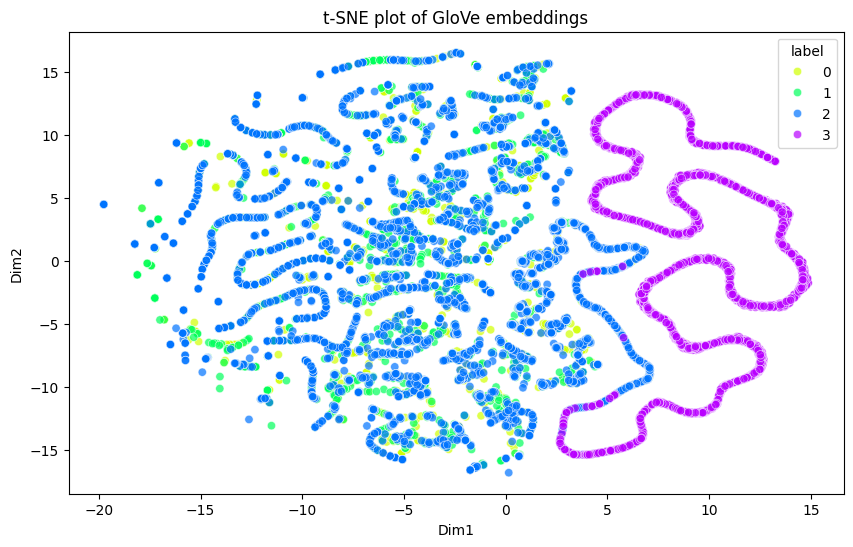

In [80]:
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
data1 = pd.read_csv('/content/reduced_4gram.csv')  # Update with your file path
# Assuming your CSV file has columns for each GloVe embedding dimension, e.g., 'glove_1', 'glove_2', ..., 'glove_100'
# And a column named 'label' for the joke type

features = data1.iloc[:, 2:].values  # Adjust the column index if needed
labels = data['joke_type'].values  # Assuming 'joke_type' is the column name for labels


# Apply t-SNE
tsne_model = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)
tsne_features = tsne_model.fit_transform(features)

# Create a DataFrame for the t-SNE results
tsne_df = pd.DataFrame(tsne_features, columns=['Dim1', 'Dim2'])
tsne_df['label'] = labels

# Plot using seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='Dim1', y='Dim2',
    hue='label',
    palette=sns.color_palette("hsv", len(set(labels))),
    data=tsne_df,
    legend="full",
    alpha=0.7
)
plt.title('t-SNE plot of GloVe embeddings')
plt.show()


SVM

In [81]:

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize SVM classifier with specific hyperparameters
svm = SVC(kernel='rbf')

# Train the SVM classifier
svm.fit(X_train_scaled, y_train)

# Predict labels for test set
y_pred = svm.predict(X_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.5665599268069533


In [82]:
from sklearn.metrics import classification_report, accuracy_score

# Calculate overall accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Overall Accuracy:", accuracy)

# Calculate precision, recall, f1-score, and support for each class and overall
report = classification_report(y_test, y_pred, digits=4)
print("Classification Report:\n", report)

# Calculate accuracy for each class
accuracy_per_class = {}
for label in set(y_test):
    mask = (y_test == label)
    accuracy_per_class[label] = accuracy_score(y_test[mask], y_pred[mask])

# Print accuracy for each class
print("\nAccuracy per class:")
for label, acc in accuracy_per_class.items():
    print(f"Class '{label}': {acc:.4f}")


Overall Accuracy: 0.5665599268069533
Classification Report:
               precision    recall  f1-score   support

           0     0.3814    0.5983    0.4658      1088
           1     0.4441    0.3920    0.4164      1125
           2     0.5299    0.2873    0.3726      1079
           3     0.9890    0.9954    0.9922      1080

    accuracy                         0.5666      4372
   macro avg     0.5861    0.5683    0.5618      4372
weighted avg     0.5843    0.5666    0.5601      4372


Accuracy per class:
Class '0': 0.5983
Class '1': 0.3920
Class '2': 0.2873
Class '3': 0.9954


In [83]:

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize SVM classifier with specific hyperparameters
svm = SVC(kernel='poly')

# Train the SVM classifier
svm.fit(X_train_scaled, y_train)

# Predict labels for test set
y_pred = svm.predict(X_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.5434583714547118


In [84]:
from sklearn.metrics import classification_report, accuracy_score

# Calculate overall accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Overall Accuracy:", accuracy)

# Calculate precision, recall, f1-score, and support for each class and overall
report = classification_report(y_test, y_pred, digits=4)
print("Classification Report:\n", report)

# Calculate accuracy for each class
accuracy_per_class = {}
for label in set(y_test):
    mask = (y_test == label)
    accuracy_per_class[label] = accuracy_score(y_test[mask], y_pred[mask])

# Print accuracy for each class
print("\nAccuracy per class:")
for label, acc in accuracy_per_class.items():
    print(f"Class '{label}': {acc:.4f}")


Overall Accuracy: 0.5434583714547118
Classification Report:
               precision    recall  f1-score   support

           0     0.3023    0.0239    0.0443      1088
           1     0.3749    0.9467    0.5371      1125
           2     0.6053    0.2132    0.3153      1079
           3     0.9906    0.9769    0.9837      1080

    accuracy                         0.5435      4372
   macro avg     0.5683    0.5401    0.4701      4372
weighted avg     0.5658    0.5435    0.4700      4372


Accuracy per class:
Class '0': 0.0239
Class '1': 0.9467
Class '2': 0.2132
Class '3': 0.9769


  RF

In [85]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the Random Forest classifier
rf.fit(X_train_scaled, y_train)

# Predict labels for test set
y_pred = rf.predict(X_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.593092406221409


In [86]:
from sklearn.metrics import classification_report, accuracy_score

# Calculate overall accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Overall Accuracy:", accuracy)

# Calculate precision, recall, f1-score, and support for each class and overall
report = classification_report(y_test, y_pred, digits=4)
print("Classification Report:\n", report)

# Calculate accuracy for each class
accuracy_per_class = {}
for label in set(y_test):
    mask = (y_test == label)
    accuracy_per_class[label] = accuracy_score(y_test[mask], y_pred[mask])

# Print accuracy for each class
print("\nAccuracy per class:")
for label, acc in accuracy_per_class.items():
    print(f"Class '{label}': {acc:.4f}")


Overall Accuracy: 0.593092406221409
Classification Report:
               precision    recall  f1-score   support

           0     0.4615    0.5064    0.4829      1088
           1     0.4477    0.4258    0.4364      1125
           2     0.4794    0.4532    0.4659      1079
           3     0.9871    0.9944    0.9908      1080

    accuracy                         0.5931      4372
   macro avg     0.5939    0.5950    0.5940      4372
weighted avg     0.5922    0.5931    0.5922      4372


Accuracy per class:
Class '0': 0.5064
Class '1': 0.4258
Class '2': 0.4532
Class '3': 0.9944


xg boost

In [87]:


# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize XGBoost classifier
xgb_clf = xgb.XGBClassifier(objective='multi:softprob', use_label_encoder=False, eval_metric='mlogloss', random_state=42)

# Train the XGBoost classifier
xgb_clf.fit(X_train_scaled, y_train)

# Predict labels for test set
y_pred = xgb_clf.predict(X_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.5823421774931381


In [ ]:
from sklearn.metrics import classification_report, accuracy_score

# Calculate overall accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Overall Accuracy:", accuracy)

# Calculate precision, recall, f1-score, and support for each class and overall
report = classification_report(y_test, y_pred, digits=4)
print("Classification Report:\n", report)

# Calculate accuracy for each class
accuracy_per_class = {}
for label in set(y_test):
    mask = (y_test == label)
    accuracy_per_class[label] = accuracy_score(y_test[mask], y_pred[mask])

# Print accuracy for each class
print("\nAccuracy per class:")
for label, acc in accuracy_per_class.items():
    print(f"Class '{label}': {acc:.4f}")


Overall Accuracy: 0.5580969807868252
Classification Report:
               precision    recall  f1-score   support

           0     0.3903    0.6582    0.4900      1662
           1     0.9823    0.9914    0.9868      1621
           2     0.5087    0.3382    0.4063      1641
           3     0.3930    0.2472    0.3035      1634

    accuracy                         0.5581      6558
   macro avg     0.5686    0.5588    0.5467      6558
weighted avg     0.5669    0.5581    0.5454      6558


Accuracy per class:
Class '0': 0.6582
Class '1': 0.9914
Class '2': 0.3382
Class '3': 0.2472


KNN

In [88]:
from sklearn.neighbors import KNeighborsClassifier

# Initialize k-NN classifier
knn_clf = KNeighborsClassifier(n_neighbors=9)  # You can adjust the number of neighbors (k) as needed

# Train the k-NN classifier
knn_clf.fit(X_train_scaled, y_train)

# Predict labels for test set
y_pred = knn_clf.predict(X_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.5555809698078683


In [89]:
from sklearn.metrics import classification_report, accuracy_score

# Calculate overall accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Overall Accuracy:", accuracy)

# Calculate precision, recall, f1-score, and support for each class and overall
report = classification_report(y_test, y_pred, digits=4)
print("Classification Report:\n", report)

# Calculate accuracy for each class
accuracy_per_class = {}
for label in set(y_test):
    mask = (y_test == label)
    accuracy_per_class[label] = accuracy_score(y_test[mask], y_pred[mask])

# Print accuracy for each class
print("\nAccuracy per class:")
for label, acc in accuracy_per_class.items():
    print(f"Class '{label}': {acc:.4f}")


Overall Accuracy: 0.5555809698078683
Classification Report:
               precision    recall  f1-score   support

           0     0.3945    0.5101    0.4449      1088
           1     0.4233    0.3876    0.4046      1125
           2     0.4401    0.3540    0.3924      1079
           3     0.9897    0.9778    0.9837      1080

    accuracy                         0.5556      4372
   macro avg     0.5619    0.5574    0.5564      4372
weighted avg     0.5602    0.5556    0.5547      4372


Accuracy per class:
Class '0': 0.5101
Class '1': 0.3876
Class '2': 0.3540
Class '3': 0.9778


NTK

In [91]:
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Ensure X_train and y_train are numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)

# Check the length of the dataset
dataset_length = len(X_train)

# Ensure that the dataset contains at least 1000 elements
if dataset_length >= 1000:
    # Use stratified sampling to ensure class balance in the sampled subset
    X_train_subset, _, y_train_subset, _ = train_test_split(
        X_train, y_train, train_size=4000, stratify=y_train, random_state=42
    )

    # Initialize NTK kernel (this assumes you have the NTK implementation)
    kernel_ntk = NTK(depth=5)

    # Initialize SVM classifier with NTK kernel
    SVCClf = SVC(kernel=kernel_ntk)

    # Train the classifier
    SVCClf.fit(X_train_subset, y_train_subset)

    # Assuming X_test, y_test are your test data
    X_test = np.array(X_test)
    y_test = np.array(y_test)

    # Make predictions
    y_pred = SVCClf.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)
else:
    print("Dataset does not contain enough elements for 1000 random jokes.")


Accuracy: 0.5521500457456542


In [92]:
from sklearn.metrics import classification_report, accuracy_score

# Calculate overall accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Overall Accuracy:", accuracy)

# Calculate precision, recall, f1-score, and support for each class and overall
report = classification_report(y_test, y_pred, digits=4)
print("Classification Report:\n", report)

# Calculate accuracy for each class
accuracy_per_class = {}
for label in set(y_test):
    mask = (y_test == label)
    accuracy_per_class[label] = accuracy_score(y_test[mask], y_pred[mask])

# Print accuracy for each class
print("\nAccuracy per class:")
for label, acc in accuracy_per_class.items():
    print(f"Class '{label}': {acc:.4f}")


Overall Accuracy: 0.5521500457456542
Classification Report:
               precision    recall  f1-score   support

           0     0.3777    0.4329    0.4034      1088
           1     0.4042    0.4764    0.4374      1125
           2     0.4730    0.3170    0.3796      1079
           3     0.9898    0.9861    0.9879      1080

    accuracy                         0.5522      4372
   macro avg     0.5612    0.5531    0.5521      4372
weighted avg     0.5593    0.5522    0.5507      4372


Accuracy per class:
Class '0': 0.4329
Class '1': 0.4764
Class '2': 0.3170
Class '3': 0.9861
